# Decision Tree Regressor: Complete Mathematical Walkthrough
This notebook explains every step of the Decision Tree Regressor algorithm with mathematics and visualizations

## Initial Setup
### Import the necessary libraries in order for this model to function

In [14]:
# Import needed libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [15]:
# Set random seed for reproducibility
np.random.seed(42)

## CONFIGURATION: Choose Your Dataset
### Dataset Options:
1. **California Housing Dataset** (default) - Built-in sklearn dataset
2. **Your Own Dataset** - Load from CSV file

In [16]:
# Option 1: Use default California Housing dataset
USE_DEFAULT_DATASET = True  # Set to False to use your own dataset

# Option 2: If using your own dataset, specify the file path and column names
YOUR_DATASET_PATH = "your_dataset.csv"  # Replace with your CSV file path
TARGET_COLUMN = "price"  # Replace with your target column name
FEATURE_COLUMNS = None  # None means use all columns except target, or specify a list like ["feature1", "feature2"]

print("="*70)
print("LOADING DATASET")
print("="*70)

if USE_DEFAULT_DATASET:
    # Load California Housing dataset
    from sklearn.datasets import fetch_california_housing
    
    housing = fetch_california_housing(as_frame=True)
    df = housing.frame
    
    # For clearer interpretation, let's focus on a subset of features
    feature_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']
    target_col = 'MedHouseVal'
    
    X = df[feature_cols].values
    y = df[target_col].values
    
    feature_names = feature_cols
    target_name = target_col
    
    print("Loaded California Housing Dataset")
    print(f"  Samples: {len(df)}")
    print(f"  Features: {feature_cols}")
    print(f"  Target: {target_col} (in $100,000s)")
    print(f"\nDataset Info:")
    print(f"  - MedInc: Median income in block group")
    print(f"  - HouseAge: Median house age in block group")
    print(f"  - AveRooms: Average number of rooms per household")
    print(f"  - AveBedrms: Average number of bedrooms per household")
    print(f"  - Population: Block group population")
    
else:
    # Load your custom dataset
    try:
        df = pd.read_csv(YOUR_DATASET_PATH)
        print(f"Loaded custom dataset from: {YOUR_DATASET_PATH}")
        
        # Prepare features and target
        if FEATURE_COLUMNS is None:
            feature_cols = [col for col in df.columns if col != TARGET_COLUMN]
        else:
            feature_cols = FEATURE_COLUMNS
        
        target_col = TARGET_COLUMN
        
        # Handle non-numeric columns (basic preprocessing)
        df_numeric = df[feature_cols + [target_col]].select_dtypes(include=[np.number])
        
        if len(df_numeric.columns) < len(feature_cols) + 1:
            print("\nWarning: Some columns are non-numeric and were removed.")
            print(f"Keeping only numeric columns: {list(df_numeric.columns)}")
        
        # Drop any rows with missing values
        df_numeric = df_numeric.dropna()
        
        X = df_numeric[feature_cols].values
        y = df_numeric[target_col].values
        
        feature_names = feature_cols
        target_name = target_col
        
        print(f"  Samples: {len(df_numeric)}")
        print(f"  Features: {feature_cols}")
        print(f"  Target: {target_col}")
        
    except FileNotFoundError:
        print(f"Error: Could not find file '{YOUR_DATASET_PATH}'")
        print("Using California Housing dataset as fallback...")
        USE_DEFAULT_DATASET = True
        # Recursively load default dataset (simplified)
        from sklearn.datasets import fetch_california_housing
        housing = fetch_california_housing(as_frame=True)
        df = housing.frame
        feature_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']
        target_col = 'MedHouseVal'
        X = df[feature_cols].values
        y = df[target_col].values
        feature_names = feature_cols
        target_name = target_col

    # Display basic statistics
    print("\n" + "="*70)
    print("DATASET STATISTICS")
    print("="*70)
    print(f"\nTarget variable ({target_name}):")
    print(f"  Mean: {np.mean(y):.2f}")
    print(f"  Std:  {np.std(y):.2f}")
    print(f"  Min:  {np.min(y):.2f}")
    print(f"  Max:  {np.max(y):.2f}")

    print(f"\nFeature ranges:")
    for i, name in enumerate(feature_names):
        print(f"  {name}: [{np.min(X[:, i]):.2f}, {np.max(X[:, i]):.2f}]")

LOADING DATASET
Loaded California Housing Dataset
  Samples: 20640
  Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population']
  Target: MedHouseVal (in $100,000s)

Dataset Info:
  - MedInc: Median income in block group
  - HouseAge: Median house age in block group
  - AveRooms: Average number of rooms per household
  - AveBedrms: Average number of bedrooms per household
  - Population: Block group population


In [17]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nSplit into training ({len(X_train)}) and test ({len(X_test)}) sets")


Split into training (16512) and test (4128) sets


# Section I. Decision Tree Regressors

A **Decision Tree Regressor** is a supervised learning algorithm that predicts continuous values by 
recursively partitioning the feature space into regions and predicting the mean value of training 
samples in each region.

## Key Concepts:
- **Recursive Binary Splitting**: The feature space is split recursively into smaller regions
- **Greedy Algorithm**: At each step, the best split is chosen without looking ahead
- **Prediction**: The mean of training samples in a leaf node becomes the prediction

# Section II. Mathematical Foundation

## The Splitting Criterion

At each node, we want to find the best feature $j$ and threshold $t$ to split the data. 
The goal is to minimize the **Mean Squared Error (MSE)** after the split.

### MSE for a Node

For a node $m$ with $n_m$ samples, the MSE is:

$$
\text{MSE}_m = \frac{1}{n_m} \sum_{i \in D_m} (y_i - \bar{y}_m)^2
$$

where:
- $D_m$ is the set of training samples in node $m$
- $y_i$ is the actual target value for sample $i$
- $\bar{y}_m = \frac{1}{n_m} \sum_{i \in D_m} y_i$ is the mean target value in node $m$

### Cost Function for a Split

When we split node $m$ into left child $m_L$ and right child $m_R$ using feature $j$ 
and threshold $t$, the weighted MSE is:

$$
J(j, t) = \frac{n_{m_L}}{n_m} \text{MSE}_{m_L} + \frac{n_{m_R}}{n_m} \text{MSE}_{m_R}
$$

where:
- $n_{m_L}$ = number of samples in left child
- $n_{m_R}$ = number of samples in right child
- $n_m = n_{m_L} + n_{m_R}$

### Optimal Split

We search for the pair $(j, t)$ that minimizes $J(j, t)$:

$$
(j^*, t^*) = \arg\min_{j,t} J(j, t)
$$

This is done through **exhaustive search** over all features and all possible thresholds.

# Section III. How Decision Trees Find the Best Split

Let's take a small sample from our dataset and manually walk through how the algorithm
finds the best split. We'll use the first 15 samples and focus on one feature.

In [18]:
# Take a small sample for demonstration
sample_size = 15
X_sample = X_train[:sample_size, 0].reshape(-1, 1)  # Use first feature
y_sample = y_train[:sample_size]

# Sort by feature value for clarity
sort_idx = np.argsort(X_sample.flatten())
X_sample = X_sample[sort_idx]
y_sample = y_sample[sort_idx]

print("="*70)
print(f"SAMPLE DATA: First {sample_size} samples, using feature '{feature_names[0]}'")
print("="*70)
print(f"\n{'Index':<8} {feature_names[0]:<15} {target_name:<15}")
print("-"*70)
for i in range(len(X_sample)):
    print(f"{i:<8} {X_sample[i][0]:<15.3f} {y_sample[i]:<15.3f}")

SAMPLE DATA: First 15 samples, using feature 'MedInc'

Index    MedInc          MedHouseVal    
----------------------------------------------------------------------
0        1.500           1.398          
1        1.942           0.934          
2        2.097           1.875          
3        2.230           1.594          
4        2.519           1.573          
5        2.812           2.299          
6        2.875           0.960          
7        3.260           1.030          
8        3.554           0.965          
9        3.812           3.821          
10       4.156           1.726          
11       4.217           2.319          
12       6.427           3.156          
13       6.623           2.648          
14       7.989           5.000          


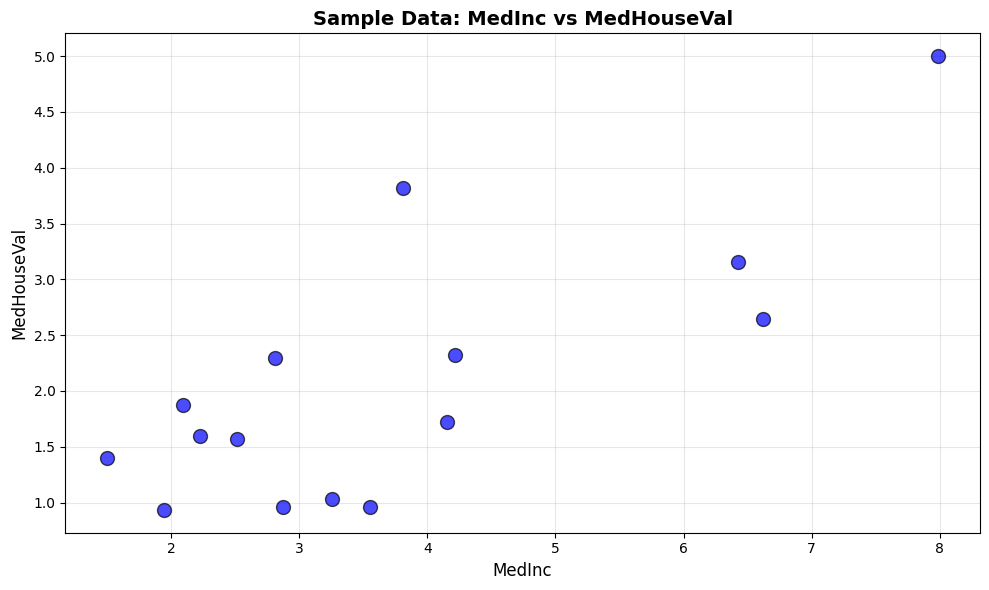

In [19]:
# Visualize the sample
plt.figure(figsize=(10, 6))
plt.scatter(X_sample, y_sample, c='blue', s=100, edgecolors='black', alpha=0.7, zorder=3)
plt.xlabel(f'{feature_names[0]}', fontsize=12)
plt.ylabel(f'{target_name}', fontsize=12)
plt.title(f'Sample Data: {feature_names[0]} vs {target_name}', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Step 1: Calculate Initial MSE (Root Node)

Before any splits, all data is at the root node. The prediction would be the mean of all y values.

$$
\bar{y}_{\text{root}} = \frac{1}{n} \sum_{i=1}^{n} y_i
$$

In [20]:
# Calculate root node statistics
y_mean_root = np.mean(y_sample)
mse_root = np.mean((y_sample - y_mean_root)**2)

print(f"\n{'='*70}")
print(f"ROOT NODE STATISTICS")
print(f"{'='*70}")
print(f"Number of samples (n): {len(y_sample)}")
print(f"Mean target value (ȳ): {y_mean_root:.3f}")
print(f"Root MSE: {mse_root:.3f}")
print(f"\nCalculation: MSE = (1/n) × Σ(yi - ȳ)²")
print(f"MSE = (1/{len(y_sample)}) × {np.sum((y_sample - y_mean_root)**2):.3f}")
print(f"MSE = {mse_root:.3f}")


ROOT NODE STATISTICS
Number of samples (n): 15
Mean target value (ȳ): 2.087
Root MSE: 1.279

Calculation: MSE = (1/n) × Σ(yi - ȳ)²
MSE = (1/15) × 19.182
MSE = 1.279


# Step 2: Finding the Best Split

We try all possible split points and calculate the weighted MSE for each.

For each potential threshold $t$ between consecutive x values:
1. Split data into left ($x \leq t$) and right ($x > t$) groups
2. Calculate MSE for each group
3. Calculate weighted average MSE
4. Choose split with minimum weighted MSE

In [21]:
def calculate_split_mse(X, y, threshold):
    """Calculate MSE for a given split threshold"""
    left_mask = X.flatten() <= threshold
    right_mask = ~left_mask
    
    if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
        return float('inf'), None, None, None, None
    
    # Left child statistics
    y_left = y[left_mask]
    y_left_mean = np.mean(y_left)
    mse_left = np.mean((y_left - y_left_mean)**2)
    
    # Right child statistics
    y_right = y[right_mask]
    y_right_mean = np.mean(y_right)
    mse_right = np.mean((y_right - y_right_mean)**2)
    
    # Weighted MSE
    n_left = len(y_left)
    n_right = len(y_right)
    n_total = n_left + n_right
    
    weighted_mse = (n_left/n_total) * mse_left + (n_right/n_total) * mse_right
    
    return weighted_mse, mse_left, mse_right, n_left, n_right

In [22]:
# Try all possible splits (between consecutive points)
possible_thresholds = [(X_sample[i] + X_sample[i+1])[0]/2 for i in range(len(X_sample)-1)]

print(f"\n{'='*70}")
print(f"EVALUATING ALL POSSIBLE SPLITS")
print(f"{'='*70}\n")

split_results = []
for threshold in possible_thresholds:
    w_mse, mse_l, mse_r, n_l, n_r = calculate_split_mse(X_sample, y_sample, threshold)
    split_results.append({
        'threshold': threshold,
        'weighted_mse': w_mse,
        'mse_left': mse_l,
        'mse_right': mse_r,
        'n_left': n_l,
        'n_right': n_r
    })
    
    if len(split_results) <= 5 or len(split_results) == len(possible_thresholds):  # Show first 5 and last
        print(f"Threshold: {feature_names[0]} ≤ {threshold:.3f}")
        print(f"  Left:  n={n_l}, MSE={mse_l:.3f}")
        print(f"  Right: n={n_r}, MSE={mse_r:.3f}")
        print(f"  Weighted MSE: {w_mse:.3f}")
        print()
    elif len(split_results) == 6:
        print("... (showing first 5 and last split) ...\n")


EVALUATING ALL POSSIBLE SPLITS

Threshold: MedInc ≤ 1.721
  Left:  n=1, MSE=0.000
  Right: n=14, MSE=1.334
  Weighted MSE: 1.245

Threshold: MedInc ≤ 2.020
  Left:  n=2, MSE=0.054
  Right: n=13, MSE=1.317
  Weighted MSE: 1.148

Threshold: MedInc ≤ 2.164
  Left:  n=3, MSE=0.148
  Right: n=12, MSE=1.415
  Weighted MSE: 1.162

Threshold: MedInc ≤ 2.375
  Left:  n=4, MSE=0.118
  Right: n=11, MSE=1.500
  Weighted MSE: 1.132

Threshold: MedInc ≤ 2.666
  Left:  n=5, MSE=0.096
  Right: n=10, MSE=1.589
  Weighted MSE: 1.092

... (showing first 5 and last split) ...

Threshold: MedInc ≤ 7.306
  Left:  n=14, MSE=0.720
  Right: n=1, MSE=0.000
  Weighted MSE: 0.672



In [23]:
# Find best split
best_split = min(split_results, key=lambda x: x['weighted_mse'])
print(f"{'='*70}")
print(f"BEST SPLIT FOUND")
print(f"{'='*70}")
print(f"Threshold: {feature_names[0]} ≤ {best_split['threshold']:.3f}")
print(f"Weighted MSE: {best_split['weighted_mse']:.3f}")
print(f"MSE Reduction: {mse_root - best_split['weighted_mse']:.3f}")
print(f"Reduction %: {((mse_root - best_split['weighted_mse'])/mse_root * 100):.1f}%")

BEST SPLIT FOUND
Threshold: MedInc ≤ 3.683
Weighted MSE: 0.578
MSE Reduction: 0.701
Reduction %: 54.8%


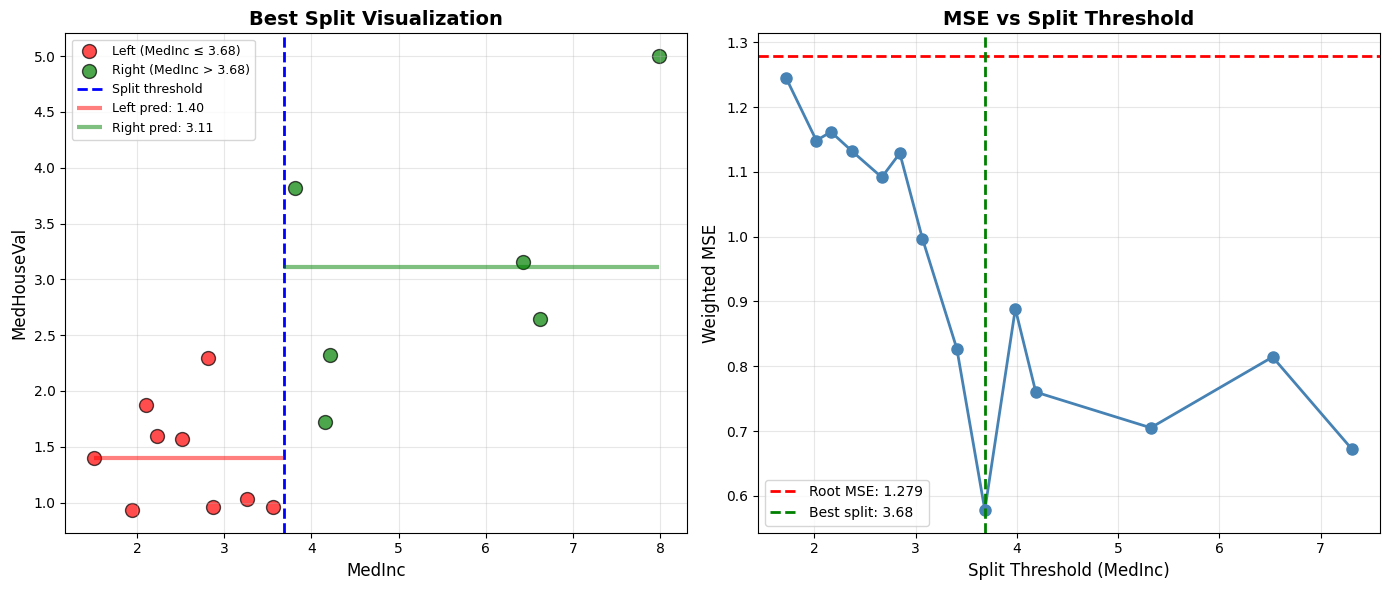

In [24]:
# Visualize the best split
plt.figure(figsize=(14, 6))

# Left panel: Show the split
plt.subplot(1, 2, 1)
left_mask = X_sample.flatten() <= best_split['threshold']
right_mask = ~left_mask

plt.scatter(X_sample[left_mask], y_sample[left_mask], c='red', s=100, 
            edgecolors='black', alpha=0.7, label=f'Left ({feature_names[0]} ≤ {best_split["threshold"]:.2f})')
plt.scatter(X_sample[right_mask], y_sample[right_mask], c='green', s=100, 
            edgecolors='black', alpha=0.7, label=f'Right ({feature_names[0]} > {best_split["threshold"]:.2f})')
plt.axvline(best_split['threshold'], color='blue', linestyle='--', linewidth=2, label='Split threshold')

# Show predictions
y_left_mean = np.mean(y_sample[left_mask])
y_right_mean = np.mean(y_sample[right_mask])
plt.hlines(y_left_mean, X_sample[left_mask].min(), best_split['threshold'], 
           colors='red', linewidth=3, alpha=0.5, label=f'Left pred: {y_left_mean:.2f}')
plt.hlines(y_right_mean, best_split['threshold'], X_sample[right_mask].max(), 
           colors='green', linewidth=3, alpha=0.5, label=f'Right pred: {y_right_mean:.2f}')

plt.xlabel(feature_names[0], fontsize=12)
plt.ylabel(target_name, fontsize=12)
plt.title('Best Split Visualization', fontsize=14, fontweight='bold')
plt.legend(fontsize=9)
plt.grid(True, alpha=0.3)

# Right panel: MSE comparison
plt.subplot(1, 2, 2)
thresholds = [s['threshold'] for s in split_results]
weighted_mses = [s['weighted_mse'] for s in split_results]

plt.plot(thresholds, weighted_mses, 'o-', linewidth=2, markersize=8, color='steelblue')
plt.axhline(mse_root, color='red', linestyle='--', linewidth=2, label=f'Root MSE: {mse_root:.3f}')
plt.axvline(best_split['threshold'], color='green', linestyle='--', linewidth=2, 
            label=f'Best split: {best_split["threshold"]:.2f}')
plt.xlabel(f'Split Threshold ({feature_names[0]})', fontsize=12)
plt.ylabel('Weighted MSE', fontsize=12)
plt.title('MSE vs Split Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 3: Recursive Splitting

The algorithm continues recursively:
1. Apply the same process to each child node
2. Continue until stopping criteria are met:
   - Maximum depth reached
   - Minimum samples per node
   - No further MSE reduction possible

## Stopping Criteria

Common hyperparameters that control tree growth:

- **max_depth**: Maximum depth of the tree
- **min_samples_split**: Minimum samples required to split a node
- **min_samples_leaf**: Minimum samples required in a leaf node
- **min_impurity_decrease**: Minimum MSE reduction required for a split

# Section IV. Training Trees with Different Depths
## Effect of Tree Depth on Model Complexity

Let's train decision trees with different max_depth values on our full dataset
and observe how they perform.

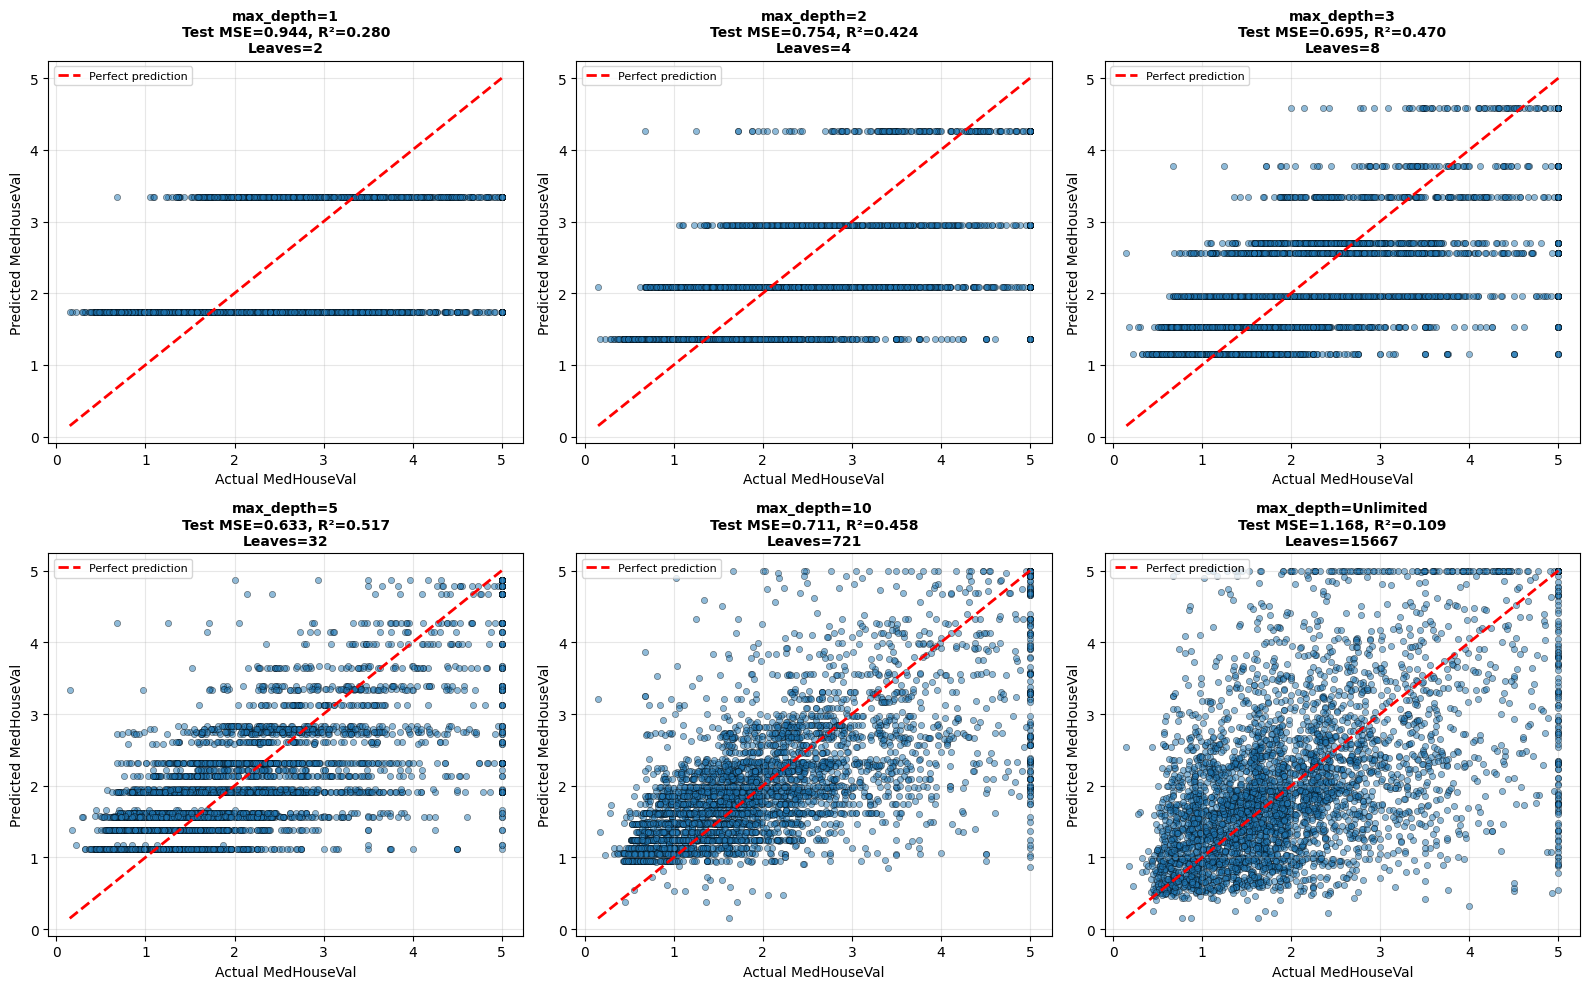


MODEL PERFORMANCE COMPARISON
Depth        Train MSE    Test MSE     Train R²     Test R²      Leaves    
------------------------------------------------------------------------------------------
1            0.913        0.944        0.317        0.280        2         
2            0.732        0.754        0.452        0.424        4         
3            0.672        0.695        0.498        0.470        8         
5            0.599        0.633        0.552        0.517        32        
10           0.498        0.711        0.628        0.458        721       
Unlimited    0.023        1.168        0.983        0.109        15667     


In [25]:
# Use first two features for 2D visualization
X_train_2d = X_train[:, :2]
X_test_2d = X_test[:, :2]

# Train trees with different depths
depths = [1, 2, 3, 5, 10, None]  # None means unlimited depth
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

results = []

for idx, depth in enumerate(depths):
    # Train model
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train_2d, y_train)
    
    # Make predictions
    y_train_pred = tree.predict(X_train_2d)
    y_test_pred = tree.predict(X_test_2d)
    
    # Calculate metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    results.append({
        'depth': depth if depth is not None else 'Unlimited',
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'n_leaves': tree.get_n_leaves()
    })
    
    # Plot: Show predictions vs actual for test set
    axes[idx].scatter(y_test, y_test_pred, alpha=0.5, s=20, edgecolors='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_test_pred.min())
    max_val = max(y_test.max(), y_test_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    depth_str = f'{depth}' if depth is not None else 'Unlimited'
    axes[idx].set_title(f'max_depth={depth_str}\nTest MSE={test_mse:.3f}, R²={test_r2:.3f}\nLeaves={tree.get_n_leaves()}', 
                        fontweight='bold', fontsize=10)
    axes[idx].set_xlabel(f'Actual {target_name}')
    axes[idx].set_ylabel(f'Predicted {target_name}')
    axes[idx].legend(loc='upper left', fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print results table
print("\n" + "="*90)
print("MODEL PERFORMANCE COMPARISON")
print("="*90)
print(f"{'Depth':<12} {'Train MSE':<12} {'Test MSE':<12} {'Train R²':<12} {'Test R²':<12} {'Leaves':<10}")
print("-"*90)
for r in results:
    print(f"{str(r['depth']):<12} {r['train_mse']:<12.3f} {r['test_mse']:<12.3f} "
          f"{r['train_r2']:<12.3f} {r['test_r2']:<12.3f} {r['n_leaves']:<10}")

# Observations on Tree Depth

- **max_depth=1**: Very simple model (one split only) - underfitting
- **max_depth=2-3**: Captures general trend reasonably well
- **max_depth=5**: Good balance between bias and variance
- **max_depth=10+**: Risk of overfitting - training error decreases but test error may increase

As depth increases:
- Training error ↓ (better fit to training data)
- Model complexity ↑ (more leaf nodes)
- Risk of overfitting ↑
- Test error may increase after a certain point

# Section V. Understanding the Tree Structure

Let's visualize a moderately-sized tree to understand how it makes decisions.

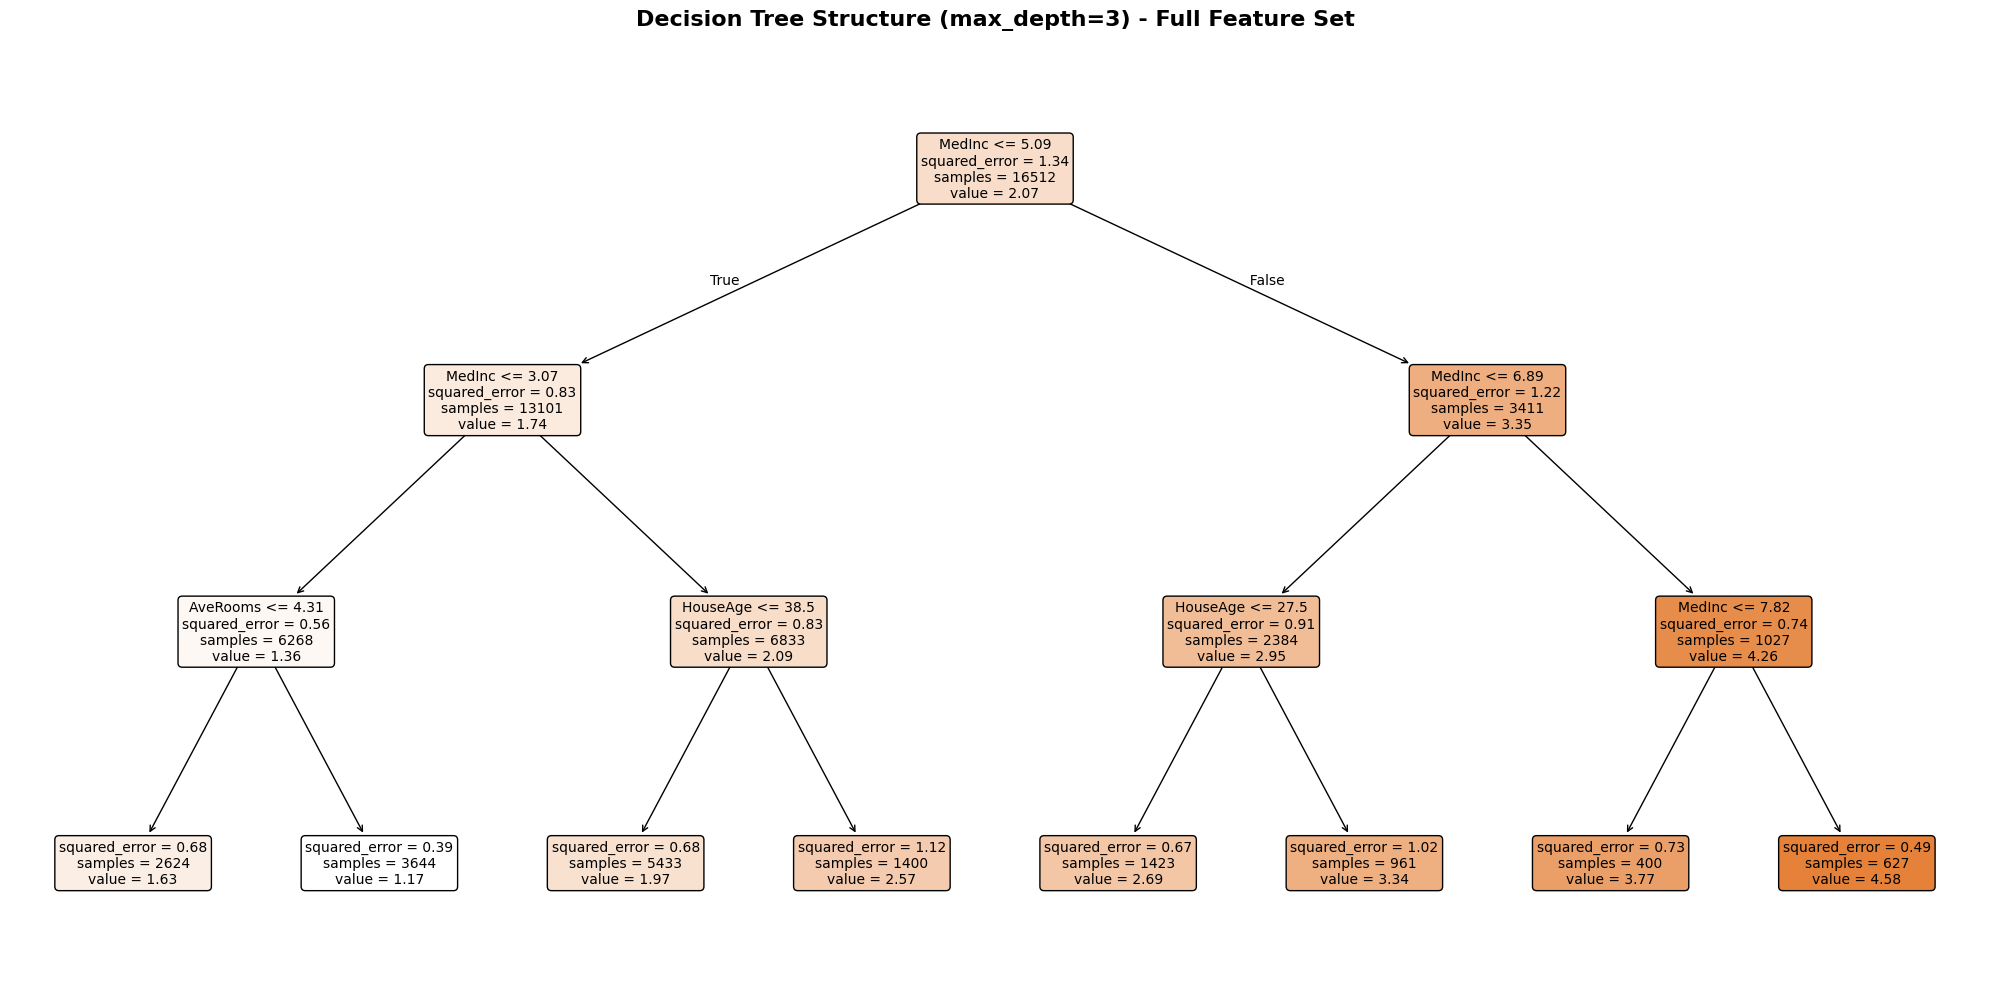

In [28]:
# Train a tree with moderate depth for visualization
tree_viz = DecisionTreeRegressor(max_depth=3, random_state=42)
tree_viz.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(tree_viz, filled=True, feature_names=feature_names, 
          rounded=True, fontsize=10, precision=2)
plt.title(f'Decision Tree Structure (max_depth=3) - Full Feature Set', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

Each node shows:
- **Split condition**: e.g., "MedInc ≤ 5.09" - the rule to split data
- **squared_error**: MSE at that node
- **samples**: Number of training samples in that node
- **value**: Predicted value (mean of samples in that node)

**Color intensity**: 
- Darker colors → lower predicted values
- Lighter colors → higher predicted values

**Leaf nodes**: 
- Terminal nodes (no further splits)
- These make the final predictions

**Decision path**: 
- Follow from root to leaf to see how a prediction is made
- Left branch = condition is True, Right branch = condition is False

# Section VI. Feature Importance

## Feature Importance Analysis

Decision trees calculate feature importance based on how much each feature 
reduces MSE across all splits.

$$
\text{Importance}(j) = \sum_{t \in \text{splits on } j} \frac{n_t}{n} \Delta \text{MSE}_t
$$

where:
- $n_t$ = number of samples at node $t$
- $n$ = total number of samples
- $\Delta \text{MSE}_t$ = MSE reduction from the split at node $t$

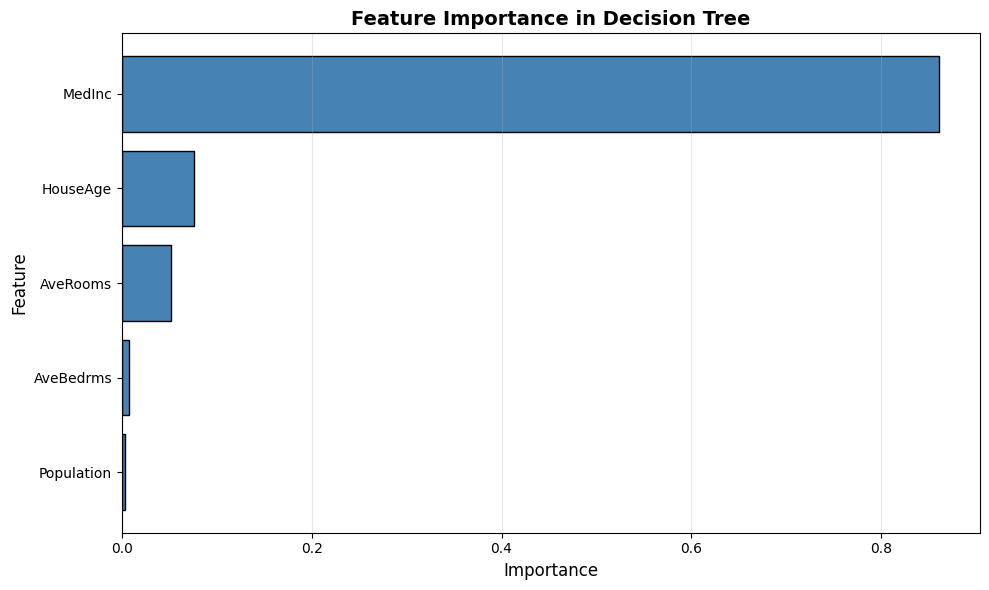


FEATURE IMPORTANCES
MedInc               0.8611
HouseAge             0.0762
AveRooms             0.0522
AveBedrms            0.0072
Population           0.0033

✓ Features with higher importance contribute more to reducing prediction error
✓ The sum of all importances equals 1.0


In [30]:
# Train model on full feature set
tree_full = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_full.fit(X_train, y_train)

# Get feature importance
importances = tree_full.feature_importances_

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=True)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance in Decision Tree', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("FEATURE IMPORTANCES")
print("="*70)
for idx, row in importance_df.sort_values('Importance', ascending=False).iterrows():
    print(f"{row['Feature']:<20} {row['Importance']:.4f}")

print("\n✓ Features with higher importance contribute more to reducing prediction error")
print("✓ The sum of all importances equals 1.0")

# Section VII. MSE vs MAE: Choosing the Right Error Metric

Decision trees can use different metrics to measure prediction error and determine splits.
The two most common are **Mean Squared Error (MSE)** and **Mean Absolute Error (MAE)**.

## Mathematical Definitions

### Mean Squared Error (MSE)
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

### Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $n$ is the number of samples.

## Key Differences

1. **Treatment of Errors**: MSE squares errors (amplifying large ones), MAE takes absolute values (linear penalty)
2. **Outlier Sensitivity**: MSE is very sensitive to outliers, MAE is robust
3. **Units**: MSE is in squared units, MAE is in original units (more interpretable)
4. **Optimization**: MSE is smooth and easier to optimize, MAE has a kink at zero

## Section VII.II Visualizing the Difference

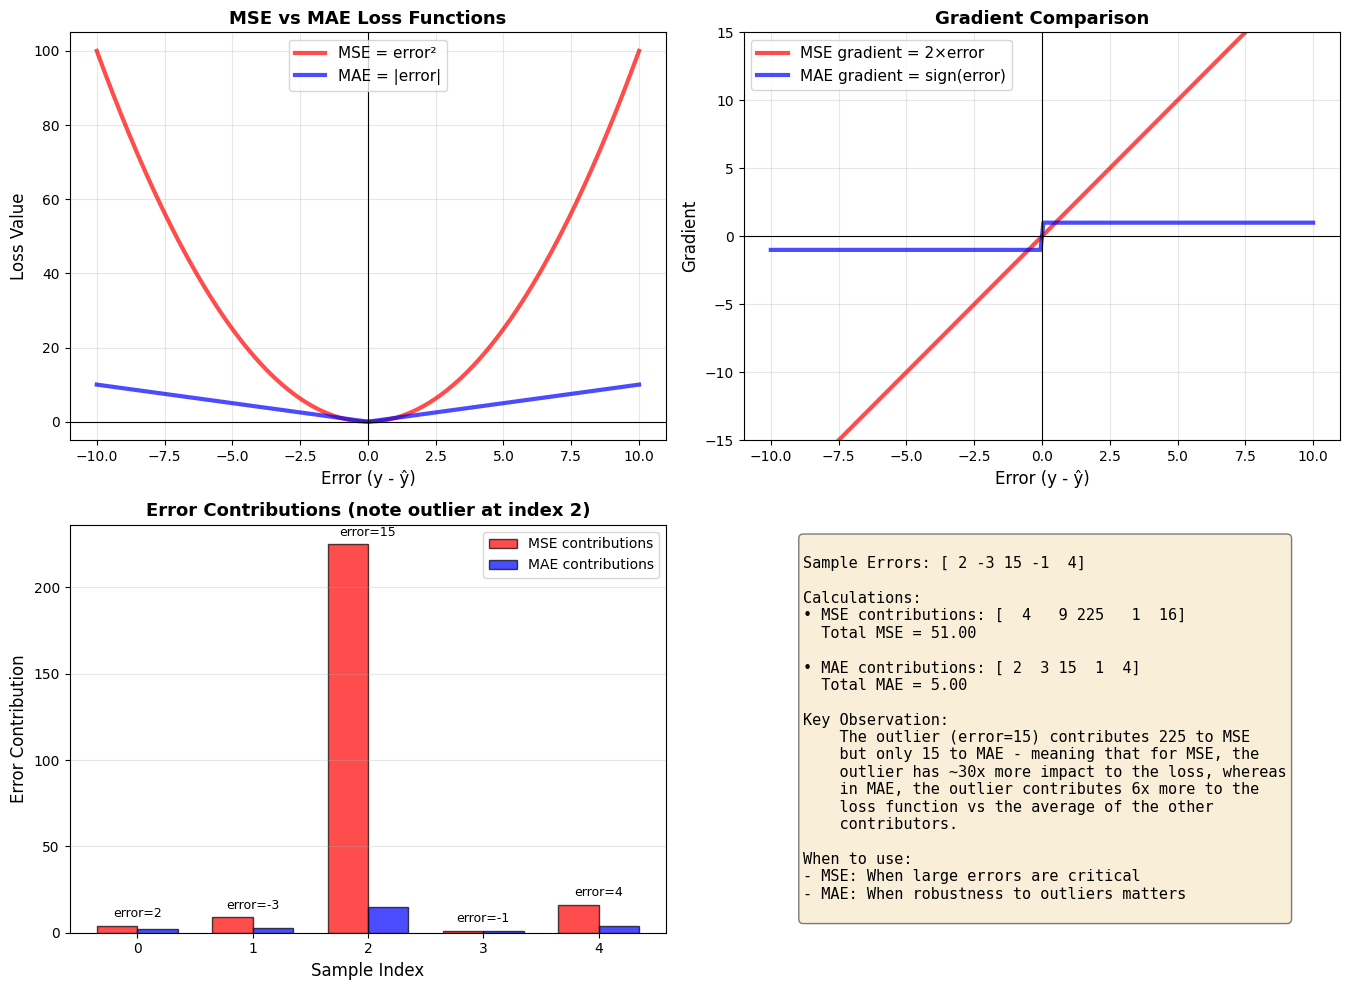

In [ ]:
# Visualize how MSE and MAE behave differently
errors = np.linspace(-10, 10, 200)
mse_values = errors**2
mae_values = np.abs(errors)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Loss functions
axes[0, 0].plot(errors, mse_values, label='MSE = error²', linewidth=3, color='red', alpha=0.7)
axes[0, 0].plot(errors, mae_values, label='MAE = |error|', linewidth=3, color='blue', alpha=0.7)
axes[0, 0].set_xlabel('Error (y - ŷ)', fontsize=12)
axes[0, 0].set_ylabel('Loss Value', fontsize=12)
axes[0, 0].set_title('MSE vs MAE Loss Functions', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axhline(0, color='black', linewidth=0.8)
axes[0, 0].axvline(0, color='black', linewidth=0.8)

# Plot 2: Gradients
mse_gradient = 2 * errors
mae_gradient = np.sign(errors)

axes[0, 1].plot(errors, mse_gradient, label='MSE gradient = 2×error', linewidth=3, color='red', alpha=0.7)
axes[0, 1].plot(errors, mae_gradient, label='MAE gradient = sign(error)', linewidth=3, color='blue', alpha=0.7)
axes[0, 1].set_xlabel('Error (y - ŷ)', fontsize=12)
axes[0, 1].set_ylabel('Gradient', fontsize=12)
axes[0, 1].set_title('Gradient Comparison', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].axhline(0, color='black', linewidth=0.8)
axes[0, 1].axvline(0, color='black', linewidth=0.8)
axes[0, 1].set_ylim(-15, 15)

# Plot 3: Concrete example with sample predictions
sample_errors = np.array([2, -3, 15, -1, 4])  # One outlier (15)
sample_indices = np.arange(len(sample_errors))

mse_contributions = sample_errors**2
mae_contributions = np.abs(sample_errors)

x_pos = np.arange(len(sample_errors))
width = 0.35

axes[1, 0].bar(x_pos - width/2, mse_contributions, width, label='MSE contributions', 
               color='red', alpha=0.7, edgecolor='black')
axes[1, 0].bar(x_pos + width/2, mae_contributions, width, label='MAE contributions', 
               color='blue', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Sample Index', fontsize=12)
axes[1, 0].set_ylabel('Error Contribution', fontsize=12)
axes[1, 0].set_title('Error Contributions (note outlier at index 2)', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Add text showing the errors
for i, err in enumerate(sample_errors):
    axes[1, 0].text(i, max(mse_contributions[i], mae_contributions[i]) + 5, 
                    f'error={err}', ha='center', fontsize=9)
    
# Plot 4: Comparison table as text
table_text = f"""
Sample Errors: {sample_errors}

Calculations:
• MSE contributions: {mse_contributions}
  Total MSE = {np.mean(mse_contributions):.2f}
  
• MAE contributions: {mae_contributions}
  Total MAE = {np.mean(mae_contributions):.2f}
"""
axes[1, 1].text(0.1, 0.5, table_text, fontsize=11, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', 
                facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

## Key Observation:
- The outlier (error=15) contributes 225 to MSE
  but only 15 to MAE 
- When using MSE, the outlier has ~30x more impact
  to the loss
- In MAE, the outlier contributes 6x more to the loss
  function vs the average of the other contributors.

### When to use:
- MSE: When large errors are critical
- MAE: When robustness to outliers matters

# Section VII.III Training Trees with Different Criteria

The scikit-learn library allows you to choose between MSE and MAE when building decision trees.

This section compares how they perform on our dataset.

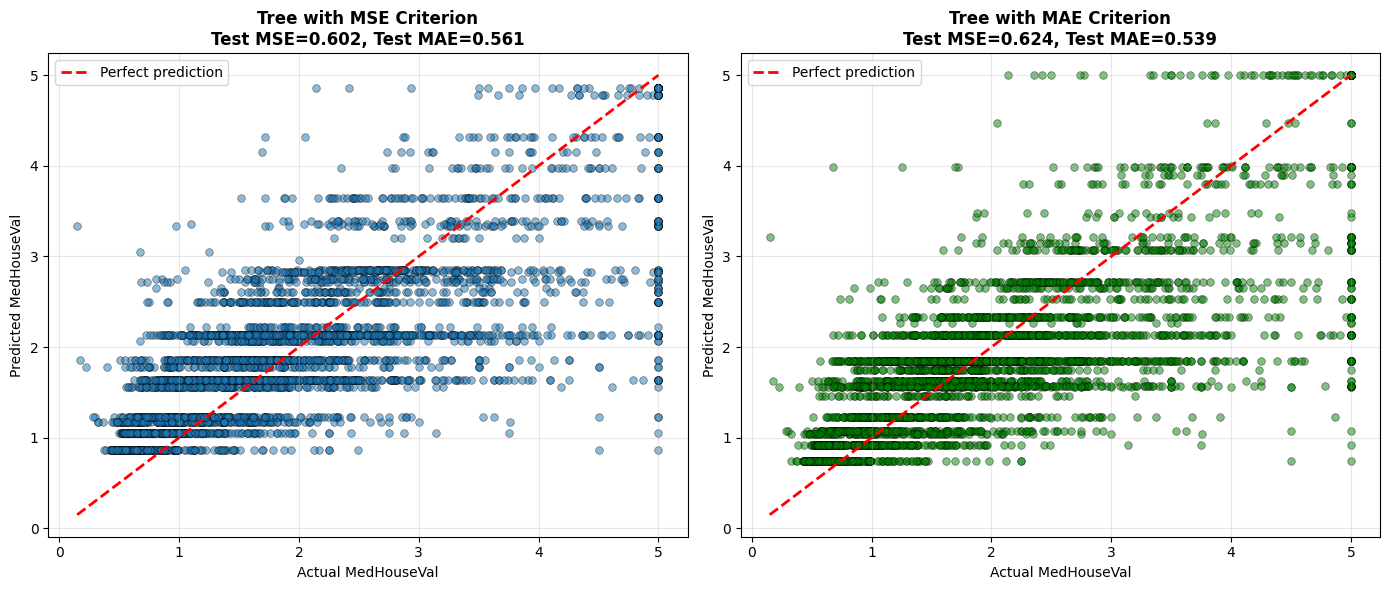


MSE vs MAE CRITERION COMPARISON

Metric               MSE Criterion        MAE Criterion       
----------------------------------------------------------------------
Train MSE            0.554                0.596               
Train MAE            0.542                0.529               
Test MSE             0.602                0.624               
Test MAE             0.561                0.539               


In [39]:
# Train trees with different criteria
tree_mse = DecisionTreeRegressor(max_depth=5, criterion='squared_error', random_state=42)
tree_mae = DecisionTreeRegressor(max_depth=5, criterion='absolute_error', random_state=42)

tree_mse.fit(X_train, y_train)
tree_mae.fit(X_train, y_train)

# Make predictions
y_train_pred_mse = tree_mse.predict(X_train)
y_train_pred_mae = tree_mae.predict(X_train)
y_test_pred_mse = tree_mse.predict(X_test)
y_test_pred_mae = tree_mae.predict(X_test)

# Calculate metrics
results_mse = {
    'train_mse': mean_squared_error(y_train, y_train_pred_mse),
    'train_mae': mean_absolute_error(y_train, y_train_pred_mse),
    'test_mse': mean_squared_error(y_test, y_test_pred_mse),
    'test_mae': mean_absolute_error(y_test, y_test_pred_mse),
}

results_mae_criterion = {
    'train_mse': mean_squared_error(y_train, y_train_pred_mae),
    'train_mae': mean_absolute_error(y_train, y_train_pred_mae),
    'test_mse': mean_squared_error(y_test, y_test_pred_mae),
    'test_mae': mean_absolute_error(y_test, y_test_pred_mae),
}

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE criterion
axes[0].scatter(y_test, y_test_pred_mse, alpha=0.5, s=30, edgecolors='black', linewidth=0.5)
min_val = min(y_test.min(), y_test_pred_mse.min())
max_val = max(y_test.max(), y_test_pred_mse.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_title(f'Tree with MSE Criterion\nTest MSE={results_mse["test_mse"]:.3f}, '
                  f'Test MAE={results_mse["test_mae"]:.3f}', fontweight='bold')
axes[0].set_xlabel(f'Actual {target_name}')
axes[0].set_ylabel(f'Predicted {target_name}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE criterion
axes[1].scatter(y_test, y_test_pred_mae, alpha=0.5, s=30, edgecolors='black', linewidth=0.5, color='green')
min_val = min(y_test.min(), y_test_pred_mae.min())
max_val = max(y_test.max(), y_test_pred_mae.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_title(f'Tree with MAE Criterion\nTest MSE={results_mae_criterion["test_mse"]:.3f}, '
                  f'Test MAE={results_mae_criterion["test_mae"]:.3f}', fontweight='bold')
axes[1].set_xlabel(f'Actual {target_name}')
axes[1].set_ylabel(f'Predicted {target_name}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("MSE vs MAE CRITERION COMPARISON")
print("="*70)
print(f"\n{'Metric':<20} {'MSE Criterion':<20} {'MAE Criterion':<20}")
print("-"*70)
print(f"{'Train MSE':<20} {results_mse['train_mse']:<20.3f} {results_mae_criterion['train_mse']:<20.3f}")
print(f"{'Train MAE':<20} {results_mse['train_mae']:<20.3f} {results_mae_criterion['train_mae']:<20.3f}")
print(f"{'Test MSE':<20} {results_mse['test_mse']:<20.3f} {results_mae_criterion['test_mse']:<20.3f}")
print(f"{'Test MAE':<20} {results_mse['test_mae']:<20.3f} {results_mae_criterion['test_mae']:<20.3f}")

# Observations on MSE vs MAE Trees

**MSE-based tree:**
- Creates splits that minimize squared errors
- More influenced by large prediction errors
- May create splits to handle extreme values
- Better when large errors are particularly costly

**MAE-based tree:**
- Creates splits that minimize absolute errors
- More robust to outliers - treats all errors more equally
- Produces more stable predictions
- Better when you want consistent performance across all samples

## Summary Table

| Aspect | MSE | MAE |
|--------|-----|-----|
| **Penalty** | Quadratic (error²) | Linear (\|error\|) |
| **Outlier sensitivity** | High | Low |
| **Units** | Squared | Original |
| **Interpretability** | Less intuitive | More intuitive |
| **Gradient** | Increases with error | Constant |
| **Use case** | Large errors critical | Robustness matters |

# Section VIII. Final Model Evaluation
In this section, we train a final model with optimized hyperparameters and evaluate its performance.

In [40]:
# Train final model
final_tree = DecisionTreeRegressor(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

final_tree.fit(X_train, y_train)

# Predictions
y_train_pred_final = final_tree.predict(X_train)
y_test_pred_final = final_tree.predict(X_test)

# Metrics
train_mse_final = mean_squared_error(y_train, y_train_pred_final)
test_mse_final = mean_squared_error(y_test, y_test_pred_final)
train_r2_final = r2_score(y_train, y_train_pred_final)
test_r2_final = r2_score(y_test, y_test_pred_final)
train_mae_final = mean_absolute_error(y_train, y_train_pred_final)
test_mae_final = mean_absolute_error(y_test, y_test_pred_final)

print("\n" + "="*70)
print("FINAL MODEL PERFORMANCE")
print("="*70)
print(f"\nHyperparameters:")
print(f"  max_depth: {final_tree.max_depth}")
print(f"  min_samples_split: {final_tree.min_samples_split}")
print(f"  min_samples_leaf: {final_tree.min_samples_leaf}")
print(f"\nMetrics:")
print(f"  Training MSE:   {train_mse_final:.4f}")
print(f"  Test MSE:       {test_mse_final:.4f}")
print(f"  Training MAE:   {train_mae_final:.4f}")
print(f"  Test MAE:       {test_mae_final:.4f}")
print(f"  Training R²:    {train_r2_final:.4f}")
print(f"  Test R²:        {test_r2_final:.4f}")
print(f"\n  Number of leaves: {final_tree.get_n_leaves()}")
print(f"  Tree depth: {final_tree.get_depth()}")


FINAL MODEL PERFORMANCE

Hyperparameters:
  max_depth: 5
  min_samples_split: 20
  min_samples_leaf: 10

Metrics:
  Training MSE:   0.5540
  Test MSE:       0.6047
  Training MAE:   0.5415
  Test MAE:       0.5620
  Training R²:    0.5856
  Test R²:        0.5386

  Number of leaves: 32
  Tree depth: 5


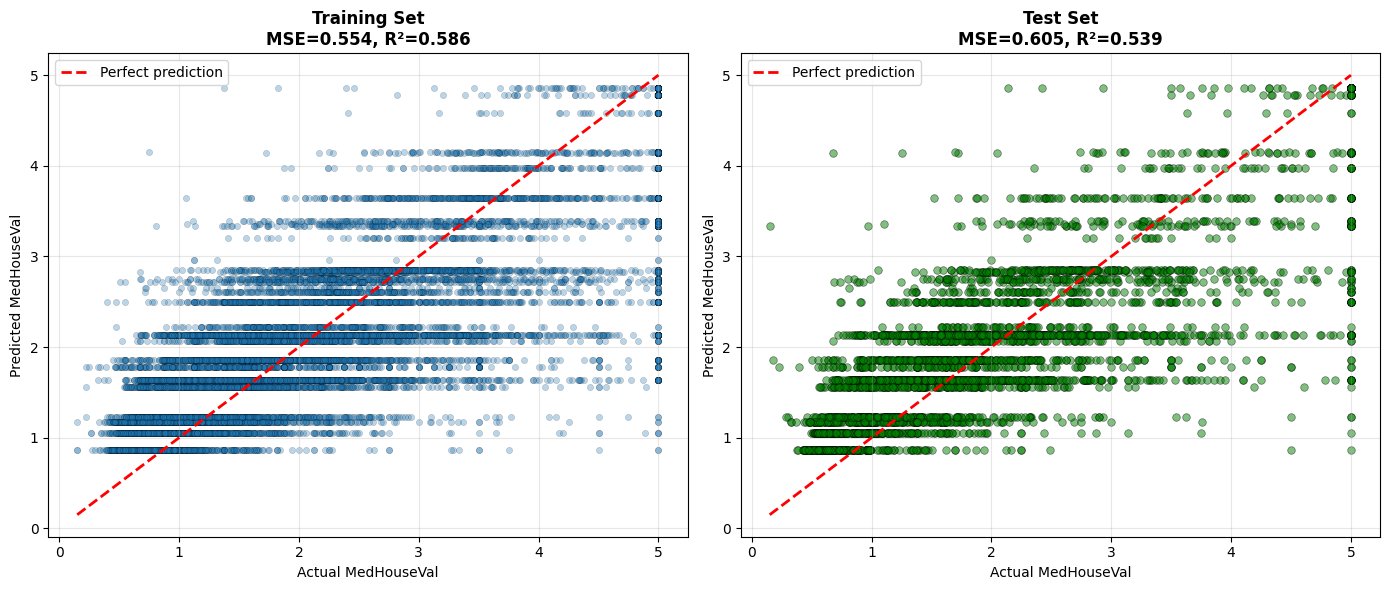

In [41]:
# Visualization: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_train_pred_final, alpha=0.3, s=20, edgecolors='black', linewidth=0.3)
min_val = min(y_train.min(), y_train_pred_final.min())
max_val = max(y_train.max(), y_train_pred_final.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[0].set_title(f'Training Set\nMSE={train_mse_final:.3f}, R²={train_r2_final:.3f}', fontweight='bold')
axes[0].set_xlabel(f'Actual {target_name}')
axes[0].set_ylabel(f'Predicted {target_name}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred_final, alpha=0.5, s=30, edgecolors='black', linewidth=0.5, color='green')
min_val = min(y_test.min(), y_test_pred_final.min())
max_val = max(y_test.max(), y_test_pred_final.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_title(f'Test Set\nMSE={test_mse_final:.3f}, R²={test_r2_final:.3f}', fontweight='bold')
axes[1].set_xlabel(f'Actual {target_name}')
axes[1].set_ylabel(f'Predicted {target_name}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

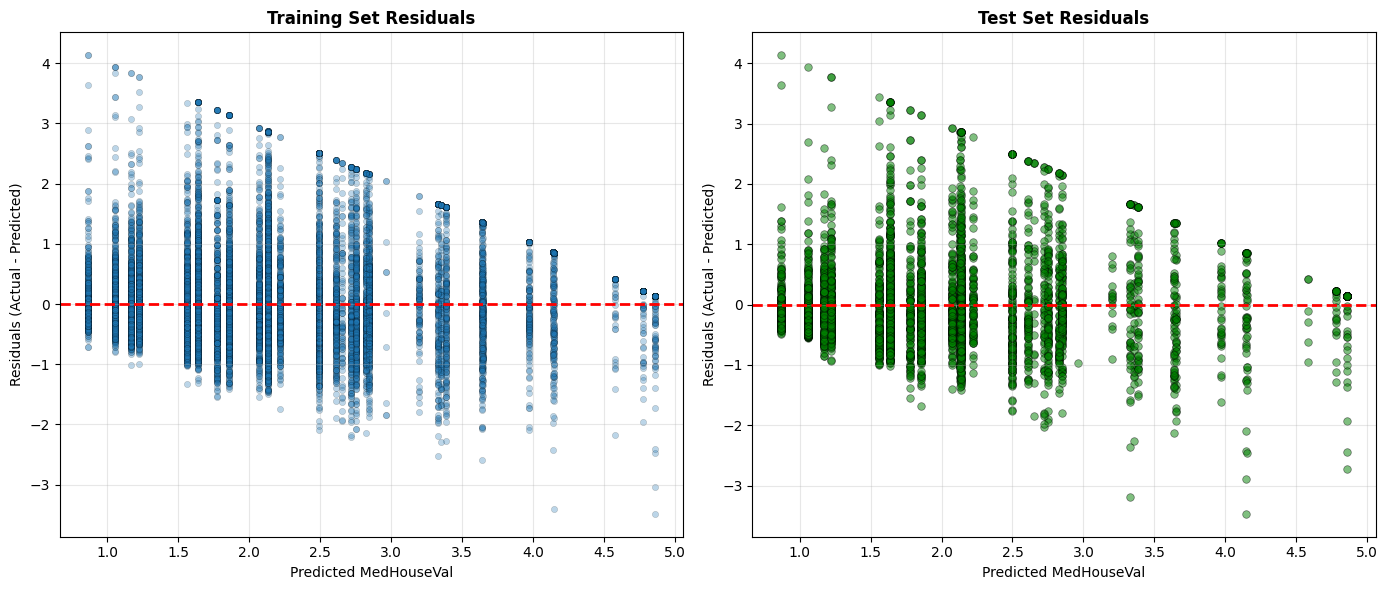

In [42]:
# Residual analysis
residuals_train = y_train - y_train_pred_final
residuals_test = y_test - y_test_pred_final

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training residuals
axes[0].scatter(y_train_pred_final, residuals_train, alpha=0.3, s=20, edgecolors='black', linewidth=0.3)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_title('Training Set Residuals', fontweight='bold')
axes[0].set_xlabel(f'Predicted {target_name}')
axes[0].set_ylabel('Residuals (Actual - Predicted)')
axes[0].grid(True, alpha=0.3)

# Test residuals
axes[1].scatter(y_test_pred_final, residuals_test, alpha=0.5, s=30, 
                edgecolors='black', linewidth=0.5, color='green')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_title('Test Set Residuals', fontweight='bold')
axes[1].set_xlabel(f'Predicted {target_name}')
axes[1].set_ylabel('Residuals (Actual - Predicted)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Section IX. Mathematical Summary

**Training Process:**
$
\text{At each node: } (j^*, t^*) = \arg\min_{j,t} \left[ \frac{n_L}{n} \text{MSE}_L + \frac{n_R}{n} \text{MSE}_R \right]
$

**Prediction:**
$
\hat{y}(\mathbf{x}) = \bar{y}_{m^*}
$
where $m^*$ is the leaf node that $\mathbf{x}$ falls into.

**Time Complexity:**
- Training: $O(n \cdot m \cdot \log n)$ where $n$ = samples, $m$ = features
- Prediction: $O(\log n)$ in average case (tree depth)

**Space Complexity:**
- $O(n)$ for storing the tree structure

# End of Tutorial

Hopefully, you now understand:
- The mathematical foundation of decision tree regressors
- How splits are chosen using MSE minimization
- The recursive splitting process
- How hyperparameters affect model complexity
- Feature importance calculation
- MSE vs MAE criterion differences
- Model evaluation and interpretation

Try experimenting with:
- Different max_depth values
- Different train/test splits
- Your own dataset (set USE_DEFAULT_DATASET = False at the top)
- Different feature combinations

In [44]:
print(f"""Dataset used: {df.shape[0]} samples with {len(feature_names)} features
Target variable: {target_name}""")

Dataset used: 20640 samples with 5 features
Target variable: MedHouseVal
